In [2]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 8
BACK_CANDLES = 10
FUTURE_DAYS = 1

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary



In [3]:
import random
stock_data = create_stock_dictionary()


In [4]:
from sklearn.model_selection import train_test_split
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
stock_data_training = {}
stock_data_testing = {}

#split data for training
for i in stock_data.keys():
    #add more features here
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    
    #change scaling algorithm
    scaler = MinMaxScaler()
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
    
    stock_data_training[i], stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)
    stock_data_testing[i].drop(['Close'], axis=1, inplace=True)

C:\Users\Rober\AppData\Local\Temp\ipykernel_17924\2692879347.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29658535 0.12931719 0.14133768 ... 0.05502429 0.04660199 0.33436724]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_17924\2692879347.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29703548 0.1582845  0.12720318 ... 0.0869435  0.07265305 0.38125801]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_17924\2692879347.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Val

In [16]:
#code that lets you select which stocks you want to train on, so you can use other stocks to train
vals = stock_data_training.values()
training_vals = ['AAPL', 'MSFT', 'YUM', 'XYL', 'GOOG']
training_df_list = []
for key in stock_data_training.keys():
    for item in training_vals:
        if(key == item):
            training_df_list.append(stock_data_training[key])
            

stacked_stock_data = pd.concat(training_df_list, ignore_index=True, axis=0)
stacked_stock_data.dropna()
stacked_stock_data.drop(['Close'], axis=1, inplace=True)
stacked_stock_data.head(15)



,Date,Open,High,Low,Adj Close,Volume,TargetNextClose
0,2022-04-07 09:30:00-04:00,0.627604,0.645420,0.629669,0.640124,0.297035,0.623686
1,2022-04-07 10:30:00-04:00,0.640066,0.635378,0.624160,0.623686,0.158285,0.624225
2,2022-04-07 11:30:00-04:00,0.623562,0.623929,0.621271,0.624225,0.127203,0.628133
3,2022-04-07 12:30:00-04:00,0.623966,0.621656,0.613814,0.628133,0.145370,0.634735
4,2022-04-07 13:30:00-04:00,0.628075,0.633570,0.626579,0.634735,0.118171,0.647834
5,2022-04-07 14:30:00-04:00,0.634340,0.645956,0.635851,0.647834,0.147731,0.641337
6,2022-04-07 15:30:00-04:00,0.647813,0.648366,0.641091,0.641337,0.159603,0.615872
7,2022-04-08 09:30:00-04:00,0.631241,0.625469,0.605079,0.615872,0.339201,0.624225
8,2022-04-08 10:30:00-04:00,0.615613,0.621585,0.610723,0.624225,0.199996,0.634398
9,2022-04-08 11:30:00-04:00,0.624370,0.627076,0.620344,0.634398,0.142385,0.623148


In [14]:
xs, ys = [], []
#for actuallly training data
for i in range(len(stacked_stock_data) - n_days): 

    v = stacked_stock_data.iloc[i:(i + n_days), :-1]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)

print(xs)
print(ys)

[[[0.62760368 0.64542048 0.62966947 0.64012404 0.29703548]
  [0.64006634 0.63537763 0.62416015 0.6236864  0.1582845 ]
  [0.62356171 0.62392884 0.62127119 0.62422525 0.12720318]
  ...
  [0.63124127 0.62546861 0.60507928 0.61587177 0.33920082]
  [0.61561264 0.62158547 0.6107229  0.62422525 0.19999643]
  [0.62437007 0.62707561 0.62034401 0.63439778 0.14238512]]

 [[0.64006634 0.63537763 0.62416015 0.6236864  0.1582845 ]
  [0.62356171 0.62392884 0.62127119 0.62422525 0.12720318]
  [0.62396589 0.62165637 0.61381361 0.62813267 0.14536972]
  ...
  [0.61561264 0.62158547 0.6107229  0.62422525 0.19999643]
  [0.62437007 0.62707561 0.62034401 0.63439778 0.14238512]
  [0.63420537 0.62653865 0.62597431 0.62314756 0.09115187]]

 [[0.62356171 0.62392884 0.62127119 0.62422525 0.12720318]
  [0.62396589 0.62165637 0.61381361 0.62813267 0.14536972]
  [0.62807529 0.63356999 0.62657896 0.63473453 0.11817108]
  ...
  [0.62437007 0.62707561 0.62034401 0.63439778 0.14238512]
  [0.63420537 0.62653865 0.6259743

In [23]:
X_test = []
Y_test = []

for key, df in stock_data_testing.items():
    if(key == 'WY'):
        if len(df) >= n_days + m_days:
            for i in range(len(df) - n_days - m_days + 1):
                X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())

            for i in range(len(df) - n_days - m_days + 1):
                Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test

array([[[0.17034064, 0.16260693, 0.17743553, 0.17633554, 0.09229478],
        [0.17535071, 0.16293616, 0.17843997, 0.17046974, 0.24016324],
        [0.15631264, 0.14944045, 0.15701369, 0.15067107, 0.10054759],
        ...,
        [0.15798262, 0.14812376, 0.15768327, 0.14932889, 0.08077978],
        [0.14896457, 0.13956555, 0.15299631, 0.14697991, 0.12934505],
        [0.14495659, 0.14680707, 0.14295282, 0.13355704, 0.10308961]],

       [[0.17535071, 0.16293616, 0.17843997, 0.17046974, 0.24016324],
        [0.15631264, 0.14944045, 0.15701369, 0.15067107, 0.10054759],
        [0.14963259, 0.14121135, 0.15935729, 0.15201339, 0.03886174],
        ...,
        [0.14896457, 0.13956555, 0.15299631, 0.14697991, 0.12934505],
        [0.14495659, 0.14680707, 0.14295282, 0.13355704, 0.10308961],
        [0.13293252, 0.12343647, 0.1335789 , 0.13489935, 0.03444077]],

       [[0.15631264, 0.14944045, 0.15701369, 0.15067107, 0.10054759],
        [0.14963259, 0.14121135, 0.15935729, 0.15201339, 0.0

In [21]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LeakyReLU

model = Sequential()
model.add(GRU(11, input_shape=(xs.shape[1], xs.shape[2])))
model.add(Dense(11))  
model.add(LeakyReLU(alpha=0.01))  # Add LeakyReLU as a separate layer with a small alpha
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(1 / 1000))
model.fit(xs, ys, epochs=1, batch_size=8, validation_split=0.2)



1335/1335 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0469 - val_loss: 0.0189


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


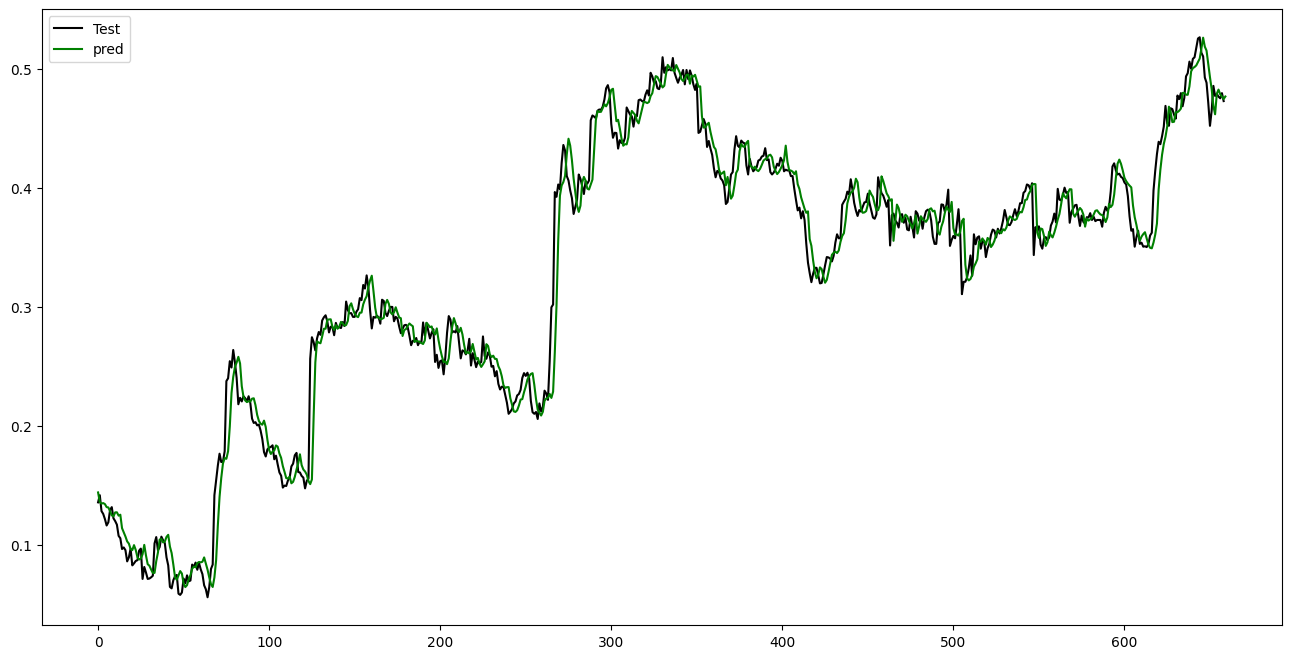

In [24]:
y_pred = model.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(Y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()
